In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from urllib.parse import urlparse
import re
from urllib.parse import urlparse
import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup

from datetime import datetime

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/capstone/url/'

In [4]:
ph_df = pd.read_csv(os.path.join(workspace_path, 'mal_domain.csv'), sep=',', header=0, engine='python', encoding='latin1')
norm = pd.read_csv(os.path.join(workspace_path, 'normal_domain.csv'), sep=',', header=0, engine='python', encoding='latin1')
norm1 = pd.read_csv(os.path.join(workspace_path, 'normal1.csv'), sep=',', header=0, engine='python')

In [5]:
# norm1['url'] = 'https://' + norm1['url']
# # ph_df['url'] = 'http://' + ph_df['url']

In [6]:
# ph_df['url'] = 'http://' + ph_df['url']

In [7]:
def remove_http_https(url):
    if url.startswith('https://'):
        return url[len('https://'):]
    elif url.startswith('http://'):
        return url[len('http://'):]
    return url

# 'url' 열에서 접두사를 제거
norm['url'] = norm['url'].apply(remove_http_https)

In [8]:
norm.head()

,url
0,beneaththemassacre.tabsnlyrics.com
1,missionsunknown.com
2,ficcifwi.com
3,theseats.com
4,starbyte.net


In [9]:
norm1.head()

,url
0,google.com
1,youtube.com
2,facebook.com
3,baidu.com
4,wikipedia.org


In [10]:
ph_df.head()

,url
0,0-01x-merchandise.554217.xyz
1,0-02pw.cfd
2,0-0llx.12313123.xyz
3,0-0lx.1231312.xyz
4,0-0lxmarket.5767435.xyz


In [11]:
ph_df.shape

(206042, 1)

In [12]:
print(ph_df.shape)
print(norm.shape)
print(norm1.shape)

(206042, 1)
(150347, 1)
(1000000, 1)


In [13]:
norm_df = pd.concat([norm[:1], norm1[:206000]], ignore_index=True)

ph_df = ph_df.sample(frac=1, random_state=41).reset_index(drop=True)
norm_df = norm_df.sample(frac=1, random_state=41).reset_index(drop=True)

In [14]:
norm_df.shape

(206001, 1)

In [15]:
ph_df.shape

(206042, 1)

In [16]:
ph_df.head(20)

,url
0,bestcustombox.com
1,www.allegrolokalnie.oferta099990.xyz
2,glo1.cfd
3,niewolno.eu
4,7j-npost.54657436.xyz
5,0d920dsa9dsa-92830dsa02.stopmonice.one
6,netmaks.online
7,as.ssilpik.site
8,allegrolokalnie.pl-platnosc-24h.pl
9,olx-pl.080708.pw


In [17]:
# from urllib.parse import urlparse

# def extract_tld(url):
#     # URL에서 마지막 '.' 이후의 부분을 TLD로 추출
#     tld = url.split('.')[-1] if '.' in url else ''
#     return tld

# def extract_tlds(df):
#     tlds = set()
#     for url in df['url']:
#         if pd.notna(url) and isinstance(url, str):
#             tld = extract_tld(url)
#             tlds.add(tld)
#     return tlds

# # 정상 URL 데이터프레임의 TLD 추출
# norm_tlds = extract_tlds(norm_df)
# print("정상 URL TLD:")
# print(norm_tlds)

# # 피싱 URL 데이터프레임의 TLD 추출
# ph_tlds = extract_tlds(ph_df)
# print("피싱 URL TLD:")
# print(ph_tlds)

In [18]:
!pip install dnspython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 4.2 MB/s eta 0:00:00


In [67]:
import re
import string
import pandas as pd
import math
import dns.resolver  # dnspython 라이브러리
from urllib.parse import urlparse

# IP 주소 여부를 확인하는 함수
def is_ip_address(hostname):
    ip_pattern = re.compile("^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$")
    return bool(ip_pattern.match(hostname))

# 자음 확인을 위한 함수
def is_consonant(char):
    return char.isalpha() and char.lower() not in ['a', 'e', 'i', 'o', 'u']

# 특수 문자 개수 계산 함수
def count_special_chars(url):
    special_chars = set(string.punctuation) # - {'-'}
    return sum(char in special_chars for char in url)


def contains_ip(url):
    return int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url)))

def max_consecutive_digits_or_special_chars(url):
    # 숫자와 특수문자를 연속적으로 매칭하는 정규 표현식
    digit_or_special_sequences = re.findall(r'[\d\W]+', url)  # 연속된 숫자나 특수문자 시퀀스

    # 각 시퀀스의 최대 길이 계산
    max_sequence_length = max([len(seq) for seq in digit_or_special_sequences], default=0)

    return max_sequence_length

# URL에서 피처 추출 함수
def extract_features(url):

    # 도메인 추출 (URL에서 호스트명 추출)
    domain = urlparse(url).hostname or url


    # IP 주소 사용 여부 피처 추가
    having_ip_address = 1 if is_ip_address(domain) else 0
    abnormal_url = 0 if url == "" else 1

    # 도메인에서 숫자의 비율 계산
    digit_count = sum(c.isdigit() for c in domain)
    digit_ratio = digit_count / len(domain) if len(domain) > 0 else 0

    # 연속된 숫자의 최대 개수 찾기
    max_consecutive_digits = 0
    current_sequence_digits = 0

    for c in url:
        if c.isdigit():
            current_sequence_digits += 1
            max_consecutive_digits = max(max_consecutive_digits, current_sequence_digits)
        else:
            current_sequence_digits = 0

    # 도메인에서 자음의 비율 계산
    consonant_count = sum(is_consonant(c) for c in url)
    consonant_ratio = consonant_count / len(domain) if len(domain) > 0 else 0

    vowels = 'aeiou'
    vowel_count = sum(1 for char in domain if char in vowels)


    # 연속된 자음의 최대 개수 찾기
    max_consecutive_consonants = 0
    current_sequence_consonants = 0

    for c in url:
        if is_consonant(c):
            current_sequence_consonants += 1
            max_consecutive_consonants = max(max_consecutive_consonants, current_sequence_consonants)
        else:
            current_sequence_consonants = 0

    # 특수 문자 개수 계산 ('-' 제외)
    special_chars_count = count_special_chars(domain)

    # TLD 추출
    tld = url.split('.')[-1] if '.' in url else ''

    # TLD에서 자음의 비율 계산
    tld_consonant_count = sum(is_consonant(c) for c in tld)
    tld_consonant_ratio = tld_consonant_count / len(tld) if len(tld) > 0 else 0

    suspicious_tlds = ['.tk', '.ga', '.ml', '.cf', '.gq', '.xyz', '.cc', '.one', '.top', '.win', ',bid'
                      '.club' , '.icu', '.work', '.info', '.pw', '.loan', '.click', '.trade', '.men', '.stream' , '.space',
                   '.domains', '.gay', '.fr', '.rentals', '.studio', '.si', '.bydgoszcz.pl', '.limanowa.pl' , '.name.ng', '.plus'
                   , '.com.gt' ,'.baby', 'energy', '.miami', '.creditcard', '.vn.ua', '.ovh', '.vu', 'com.im', '.fun', '.lic',
                   '.tv', '.su', 'codes', '.gift', '.ee', '.rw', '.sh', '.cool', 'szczecin.pl', '.plicu', '.com.', '.kim', 'love', '.co.'
                   ,'.site', '.top', '.online', '.space', '.shop', '.cfd', '.live', '.sbs', '.cyou']


    features = {
        'contains_dash': int('-' in domain),  # '-' 문자 사용 여부
        'domain_length': len(domain),  # 전체 URL 길이
        'digit_ratio': digit_ratio,  # 도메인에서 숫자의 비율
        'max_consecutive_digits': max_consecutive_digits,  # 연속된 숫자의 최대 개수
        'subdomain_count': domain.count('.'), #- (1 if url.startswith('www.') else 0),  # 서브 도메인 개수
        'consonant_ratio': consonant_ratio,  # 도메인 내의 자음 비율
        'vowel_ratio' : vowel_count / len(domain),
        'vowel_consonant_balance' : abs(consonant_count - vowel_count) / len(domain),
        'special_chars_count': special_chars_count,  # 특수 문자 개수 ('-' 제외)
        'tld_consonant_ratio': tld_consonant_ratio,  # TLD 내의 자음 비율
        'max_consecutive_consonants': max_consecutive_consonants,  # 연속된 자음의 최대 개수
        #'contains_ip' : contains_ip(domain),
        'consecutive_ds' : max_consecutive_digits_or_special_chars(domain),
        'suspicious_tld' : int(any(domain.endswith(tld) for tld in suspicious_tlds)),

    }

    return features

# 데이터프레임에 피처 추출 적용 함수
def extract_features_from_dataframe(df):
    features_list = []
    for url in df['url']:
        if pd.notna(url) and isinstance(url, str):
            features = extract_features(url)
            features_list.append(features)
        else:
            continue

    features_df = pd.DataFrame(features_list)
    return features_df


In [68]:
# 피처 추출
ph_features_df = extract_features_from_dataframe(ph_df)
norm_features_df = extract_features_from_dataframe(norm_df)

In [69]:
# !pip install tldextract

In [70]:
# import tldextract
# import pandas as pd
# from collections import Counter

# # TLD 추출 및 빈도 계산 함수
# def extract_tld_with_count(df, url_column):
#     tld_list = []  # TLD를 저장할 리스트

#     # 각 URL에서 TLD 추출
#     for url in df[url_column]:
#         extracted = tldextract.extract(url)
#         tld_list.append(extracted.suffix)  # TLD만 추출해서 리스트에 저장

#     # TLD의 빈도를 계산하여 딕셔너리로 반환
#     tld_count = Counter(tld_list)
#     return tld_count

# # 데이터프레임에서 TLD 추출 및 빈도 계산
# tld_count = extract_tld_with_count(ph_df, 'url')

# # 결과 확인
# print(tld_count)


In [71]:
# tld_list = set(tld_list)
# print(len(tld_list))
# print(tld_list)




In [72]:
# 피싱 및 정상 데이터셋에 레이블 추가
ph_features_df['label'] = 1  # 피싱 URL
norm_features_df['label'] = 0  # 정상 URL

In [214]:
# 데이터셋 병합
ph_val = ph_features_df.sample(n=30000, random_state=42)
ph_train = ph_features_df.drop(ph_val.index)

norm_val = norm_features_df.sample(n=30000, random_state=42)
norm_train = norm_features_df.drop(norm_val.index)

valset = pd.concat([ph_val, norm_val])
df = pd.concat([ph_train, norm_train], ignore_index=True)

In [215]:
ph_df.head()

,url
0,bestcustombox.com
1,www.allegrolokalnie.oferta099990.xyz
2,glo1.cfd
3,niewolno.eu
4,7j-npost.54657436.xyz


In [216]:
df.head()

,contains_dash,domain_length,digit_ratio,max_consecutive_digits,subdomain_count,consonant_ratio,vowel_ratio,vowel_consonant_balance,special_chars_count,tld_consonant_ratio,max_consecutive_consonants,consecutive_ds,suspicious_tld,label
0,0,17,0.000000,0,1,0.647059,0.294118,0.352941,1,0.666667,3,1,0,1
1,0,36,0.166667,6,3,0.472222,0.277778,0.194444,3,1.000000,3,7,1,1
2,0,8,0.125000,1,1,0.625000,0.125000,0.500000,1,1.000000,3,2,1,1
3,0,11,0.000000,0,1,0.363636,0.545455,0.181818,1,0.000000,2,1,0,1
4,1,38,0.315789,5,2,0.368421,0.236842,0.131579,3,0.333333,2,6,1,1


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352043 entries, 0 to 352042
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   contains_dash               352043 non-null  int64  
 1   domain_length               352043 non-null  int64  
 2   digit_ratio                 352043 non-null  float64
 3   max_consecutive_digits      352043 non-null  int64  
 4   subdomain_count             352043 non-null  int64  
 5   consonant_ratio             352043 non-null  float64
 6   vowel_ratio                 352043 non-null  float64
 7   vowel_consonant_balance     352043 non-null  float64
 8   special_chars_count         352043 non-null  int64  
 9   tld_consonant_ratio         352043 non-null  float64
 10  max_consecutive_consonants  352043 non-null  int64  
 11  consecutive_ds              352043 non-null  int64  
 12  suspicious_tld              352043 non-null  int64  
 13  label         

In [218]:
df_corr = df.corr(method='pearson')
df_corr

,contains_dash,domain_length,digit_ratio,max_consecutive_digits,subdomain_count,consonant_ratio,vowel_ratio,vowel_consonant_balance,special_chars_count,tld_consonant_ratio,max_consecutive_consonants,consecutive_ds,suspicious_tld,label
contains_dash,1.000000,0.379249,0.165209,0.285899,0.273429,-0.199907,-0.172846,-0.029910,0.716679,0.067088,0.023377,0.301212,0.152973,0.302225
domain_length,0.379249,1.000000,0.390287,0.489100,0.628783,-0.200263,-0.155194,-0.061446,0.670881,0.144772,0.317575,0.453154,0.118762,0.497953
digit_ratio,0.165209,0.390287,1.000000,0.894994,0.338108,-0.607139,-0.513596,-0.074208,0.325151,0.236587,0.007157,0.859630,0.155712,0.276607
max_consecutive_digits,0.285899,0.489100,0.894994,1.000000,0.410782,-0.557096,-0.454067,-0.083507,0.457063,0.233594,0.052606,0.978048,0.197292,0.326012
subdomain_count,0.273429,0.628783,0.338108,0.410782,1.000000,-0.183543,-0.349236,0.090299,0.813357,0.192902,0.210007,0.399049,0.166915,0.475048
consonant_ratio,-0.199907,-0.200263,-0.607139,-0.557096,-0.183543,1.000000,-0.292089,0.772287,-0.239525,0.139792,0.467811,-0.546796,-0.022207,-0.067785
vowel_ratio,-0.172846,-0.155194,-0.513596,-0.454067,-0.349236,-0.292089,1.000000,-0.764595,-0.329874,-0.441209,-0.431761,-0.437056,-0.184927,-0.261121
vowel_consonant_balance,-0.029910,-0.061446,-0.074208,-0.083507,0.090299,0.772287,-0.764595,1.000000,0.039811,0.325696,0.548330,-0.087325,0.099761,0.103986
special_chars_count,0.716679,0.670881,0.325151,0.457063,0.813357,-0.239525,-0.329874,0.039811,1.000000,0.160459,0.156203,0.464009,0.193262,0.476323
tld_consonant_ratio,0.067088,0.144772,0.236587,0.233594,0.192902,0.139792,-0.441209,0.325696,0.160459,1.000000,0.089183,0.224927,0.093849,0.157143


In [219]:
# df.url_length.value_counts()

In [220]:
df.label.value_counts()

,count
label,
1,176042
0,176001


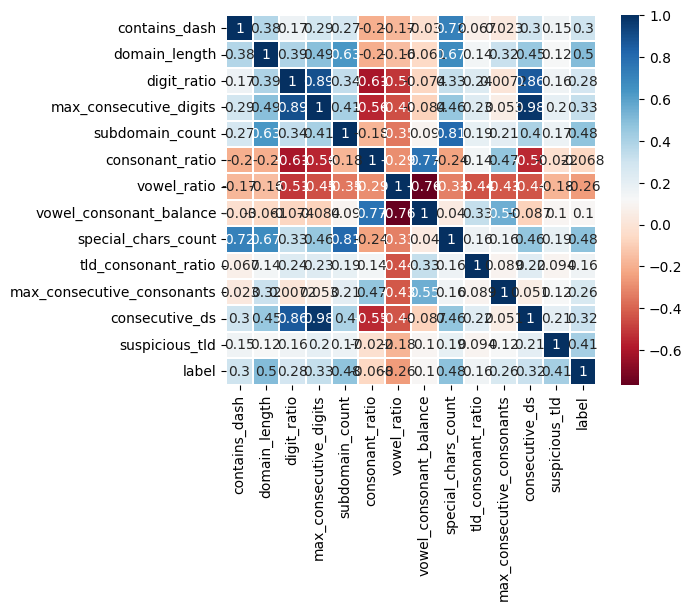

In [221]:
heatmap_data = df.select_dtypes(include=[np.number])
colormap = plt.cm.RdBu
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True,
            annot_kws={'size': 10})
plt.show()

In [222]:
# 데이터 준비 (독립 변수와 종속 변수 분리)
X = df.drop(columns=['label'])
y = df['label']
val_input = valset.drop(columns=['label'])
val_target = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input.columns = val_input.columns.str.replace('[^a-zA-Z0-9]', '_')
X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LGBM 모델

In [223]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM 모델 설정 (나머지 코드는 이전과 동일)
params = {
    'objective': 'binary',  # 이진 분류 설정
    'metric': 'binary_error',  # 이진 분류 정확도 측정
    'boosting_type': 'rf',  # Gradient Boosting Decision Tree
    'num_leaves': 63,  # 과적합 방지를 위해 트리의 최대 잎 노드 수 줄임
    'learning_rate': 0.01,  # 과적합 방지를 위해 낮은 학습률 설정
    'feature_fraction': 0.9,  # 트리마다 무작위로 선택되는 피처 비율 줄임
    'bagging_fraction': 0.9,  # 각 반복마다 무작위로 선택되는 데이터 비율 줄임
    'bagging_freq': 5,  # 5번의 반복마다 배깅 수행
    'lambda_l1': 0.1,  # L1 정규화 적용
    'lambda_l2': 0.1,  # L2 정규화 적용
    'max_depth': 15  # 과적합 방지를 위해 트리의 최대 깊이 제한
}

In [224]:
# LightGBM 모델 학습
num_round = 20  # 트리 수 (조정 가능)
lgb_model = lgb.train(params, train_data, num_round)

[LightGBM] [Info] Number of positive: 140766, number of negative: 140868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 281634, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499819 -> initscore=-0.000724
[LightGBM] [Info] Start training from score -0.000724


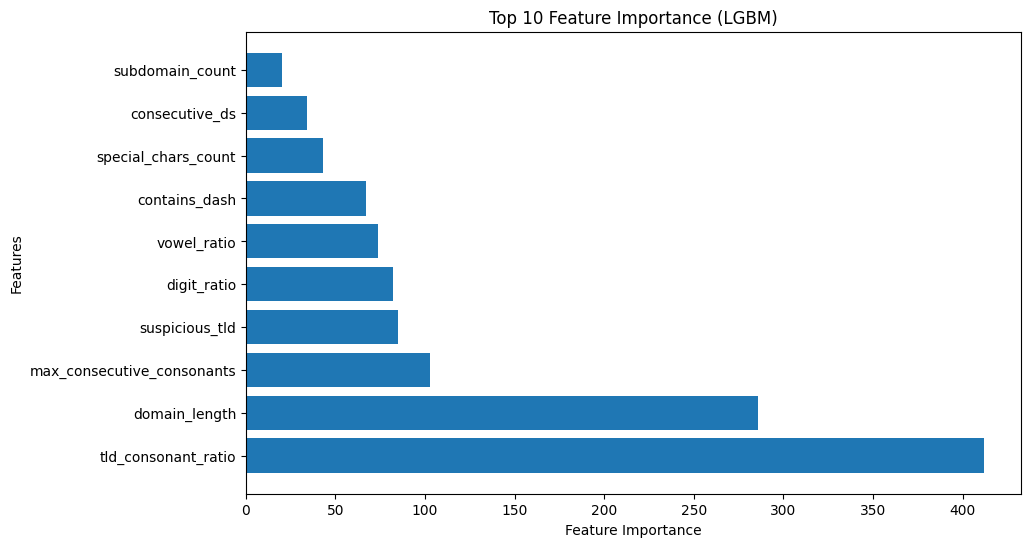

In [225]:
import matplotlib.pyplot as plt

# LightGBM 모델에서 피쳐 중요도 가져오기
feature_importance = lgb_model.feature_importance()
feature_names = X_train.columns

# 중요도를 피쳐 이름과 연결
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피쳐만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (LGBM)'.format(top_n))
plt.show()


In [226]:
# 모델 예측
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_binary_lgb = [1 if pred > 0.5 else 0 for pred in y_pred_lgb]  # 이진 예측

In [227]:
# 정확도 출력
accuracy_lgb = accuracy_score(y_test, y_pred_binary_lgb)
print("Accuracy:", accuracy_lgb)

# 분류 보고서 출력
classification_rep_lgb = classification_report(y_test, y_pred_binary_lgb)
print("Classification Report:\n", classification_rep_lgb)

# 혼동 행렬 출력
conf_matrix_lgb = confusion_matrix(y_test, y_pred_binary_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)

Accuracy: 0.8555440355636353
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.87     35133
           1       0.93      0.77      0.84     35276

    accuracy                           0.86     70409
   macro avg       0.87      0.86      0.85     70409
weighted avg       0.87      0.86      0.85     70409

Confusion Matrix:
 [[32945  2188]
 [ 7983 27293]]


In [228]:
# 검증 데이터 예측
val_pred_lgb = lgb_model.predict(val_input, num_iteration=lgb_model.best_iteration)
val_pred_binary_lgb = [1 if pred > 0.5 else 0 for pred in val_pred_lgb]  # 이진 예측

In [229]:
# 정확도 출력
accuracy_val_lgb = accuracy_score(val_target, val_pred_binary_lgb)
print("Accuracy:", accuracy_val_lgb)

# 분류 보고서 출력
classification_val_lgb = classification_report(val_target, val_pred_binary_lgb)
print("Classification Report:\n", classification_val_lgb)

Accuracy: 0.8548
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     30000
           1       0.92      0.77      0.84     30000

    accuracy                           0.85     60000
   macro avg       0.86      0.85      0.85     60000
weighted avg       0.86      0.85      0.85     60000



# RandomForest

In [230]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # 랜덤 포레스트 모델 생성 및 학습
# rf_model = RandomForestClassifier(random_state=42,
#                                    n_estimators=150,
#                                    criterion='log_loss',
#                                    n_jobs=2,

#                                    )
# rf_model.fit(X_train, y_train)

In [231]:
# import matplotlib.pyplot as plt

# # 학습된 Random Forest 모델에서 피처 중요도 가져오기
# feature_importance = rf_model.feature_importances_

# # 각 피처와 그 중요도를 연결
# feature_names = X_train.columns
# feature_importance_dict = dict(zip(feature_names, feature_importance))

# # 중요도를 기준으로 내림차순 정렬
# sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # 상위 N개의 피처만 선택 (예: 상위 10개)
# top_n = 10
# top_features = dict(sorted_feature_importance[:top_n])

# # 그래프로 시각화
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(top_features)), top_features.values(), align='center')
# plt.yticks(range(len(top_features)), top_features.keys())
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Top {} Feature Importance (Random Forest)'.format(top_n))
# plt.show()


In [232]:
# # 모델 예측
# y_pred_rf = rf_model.predict(X_test)

In [233]:
# # 정확도 출력
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# print("Accuracy:", accuracy_rf)

# # 분류 보고서 출력
# classification_rep_rf = classification_report(y_test, y_pred_rf)
# print("Classification Report:\n", classification_rep_rf)

# # 혼동 행렬 출력
# conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
# print("Confusion Matrix:\n", conf_matrix_rf)

In [234]:
# # 모델 예측
# val_pred_rf = rf_model.predict(val_input)

In [235]:
# # 정확도 출력
# accuracy_val_rf = accuracy_score(val_target, val_pred_rf)
# print("Accuracy:", accuracy_val_rf)

# # 분류 보고서 출력
# classification_val_rf = classification_report(val_target, val_pred_rf)
# print("Classification Report:\n", classification_val_rf)

# # 혼동 행렬 출력
# conf_matrix_val_rf = confusion_matrix(y_test, y_pred_rf)
# print("Confusion Matrix:\n", conf_matrix_val_rf)

# XGBOOST

In [236]:
# 데이터 준비 (독립 변수와 종속 변수 분리)
X = df.drop(columns=['label'])
y = df['label']
val_input = valset.drop(columns=['label'])
val_target = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input.columns = val_input.columns.str.replace('[^a-zA-Z0-9]', '_')
X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# XGBoost 데이터셋 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 모델 설정
params = {
    'objective': 'binary:logistic',  # 이진 분류 설정
    'eval_metric': 'error',  # 이진 분류 오류율
    'booster': 'dart',  # 트리 기반 모델
    'max_depth': 30,  # 트리의 최대 깊이
    'eta': 0.0005,  # 학습률
    'subsample': 0.9,  # 훈련 데이터의 하위 샘플 비율
    'lambda': 1
}

In [237]:
# XGBoost 모델 학습
num_round = 10  # 부스팅 라운드 수 (조정 가능)
bst = xgb.train(params, dtrain, num_round)

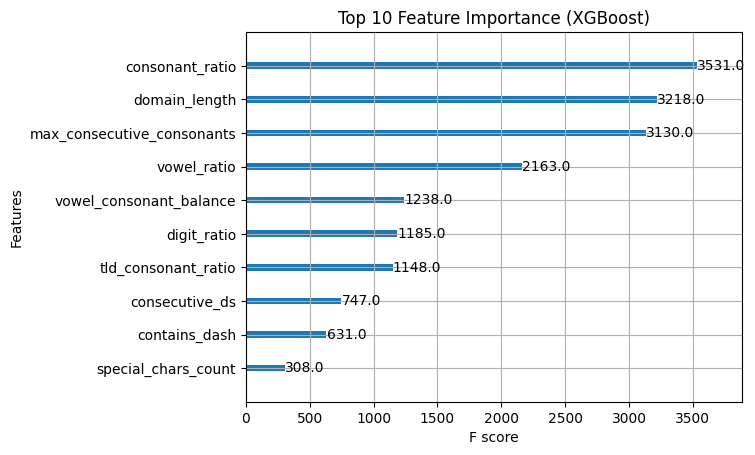

In [238]:
# 피쳐 중요도 가져오기 및 시각화
xgb.plot_importance(bst, max_num_features=10)
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()


In [239]:
# 모델 예측
y_pred_xgb = bst.predict(dtest)
y_pred_binary_xgb = [1 if pred > 0.5 else 0 for pred in y_pred_xgb]  # 이진 예측


In [240]:
# 정확도 출력
accuracy_xgb = accuracy_score(y_test, y_pred_binary_xgb)
print("Accuracy:", accuracy_xgb)


Accuracy: 0.8615233847945575


In [241]:
# 분류 보고서 출력
classification_rep_xgb = classification_report(y_test, y_pred_binary_xgb)
print("Classification Report:\n", classification_rep_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     35133
           1       0.93      0.78      0.85     35276

    accuracy                           0.86     70409
   macro avg       0.87      0.86      0.86     70409
weighted avg       0.87      0.86      0.86     70409



In [242]:
# 혼동 행렬 출력
conf_matrix_xgb = confusion_matrix(y_test, y_pred_binary_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

Confusion Matrix:
 [[33165  1968]
 [ 7782 27494]]


In [243]:
# 검증 데이터셋에 대한 예측
dval = xgb.DMatrix(val_input)
val_pred_xgb = bst.predict(dval)
val_pred_binary_xgb = [1 if pred > 0.5 else 0 for pred in val_pred_xgb]  # 이진 예측

# 정확도 출력
accuracy_val_xgb = accuracy_score(val_target, val_pred_binary_xgb)
print("Validation Accuracy:", accuracy_val_xgb)

# 분류 보고서 출력
classification_val_xgb = classification_report(val_target, val_pred_binary_xgb)  # val_pred6 대신 val_pred_binary 사용
print("Classification Report:\n", classification_val_xgb)

# 혼동 행렬 출력
conf_matrix_val_xgb = confusion_matrix(val_target, val_pred_binary_xgb)  # val_pred6 대신 val_pred_binary 사용
print("Confusion Matrix:\n", conf_matrix_val_xgb)

Validation Accuracy: 0.8605166666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     30000
           1       0.93      0.78      0.85     30000

    accuracy                           0.86     60000
   macro avg       0.87      0.86      0.86     60000
weighted avg       0.87      0.86      0.86     60000

Confusion Matrix:
 [[28286  1714]
 [ 6655 23345]]


# decision tree

In [244]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 데이터 분할 (예시)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree 모델 생성 및 학습
dt_model = DecisionTreeClassifier(max_depth=14, random_state=42,
                                  criterion='gini', min_samples_leaf=9, )
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=9, random_state=42)

In [245]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [14],
#     'min_samples_split': [2],
#     'min_samples_leaf': [9,10,11,12],
#     # 'max_features': ['sqrt', 'log2', None],
#     'criterion': ['gini']
# }

# grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)


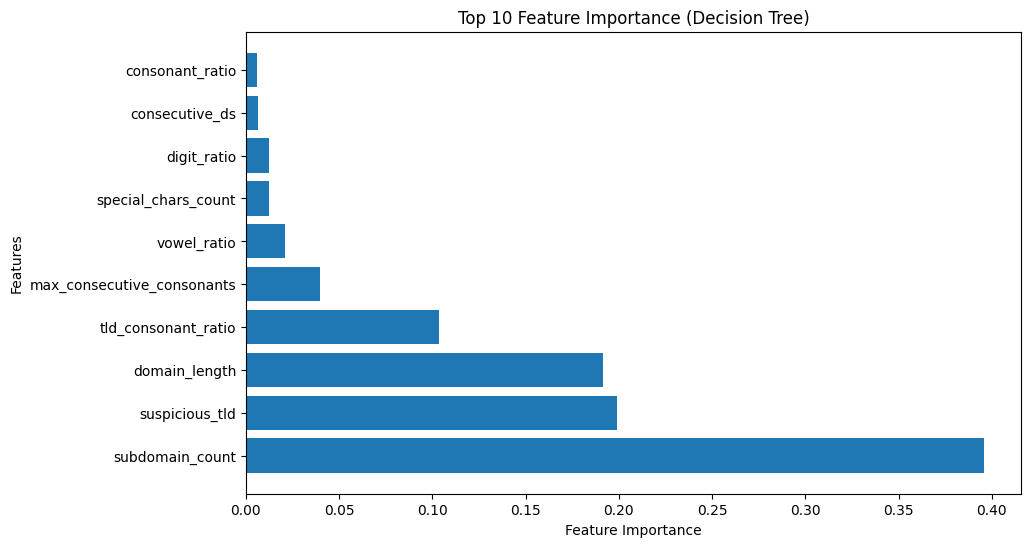

In [246]:
# 특성 중요도 가져오기
feature_importance = dt_model.feature_importances_
feature_names = X_train.columns

# 중요도를 피쳐 이름과 연결
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피쳐만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 중요도를 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance (Decision Tree)')
plt.show()

In [247]:
# 모델 예측
y_pred_dt = dt_model.predict(X_test)

# 정확도 출력
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy_dt)


Accuracy: 0.8611115056313824


In [248]:
# 분류 보고서 출력
classification_rep_dt = classification_report(y_test, y_pred_dt)
print("Classification Report:\n", classification_rep_dt)

# 혼동 행렬 출력
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", conf_matrix_dt)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     35133
           1       0.93      0.78      0.85     35276

    accuracy                           0.86     70409
   macro avg       0.87      0.86      0.86     70409
weighted avg       0.87      0.86      0.86     70409

Confusion Matrix:
 [[32977  2156]
 [ 7623 27653]]


In [249]:
# 검증 데이터 예측 (val_input, val_target가 검증 데이터라고 가정)
val_pred_dt = dt_model.predict(val_input)

# 검증 데이터 정확도 출력
accuracy_val_dt = accuracy_score(val_target, val_pred_dt)
print("Accuracy:", accuracy_val_dt)




Accuracy: 0.8603833333333334


In [250]:
# 검증 데이터 분류 보고서 출력
classification_val_dt = classification_report(val_target, val_pred_dt)
print("Classification Report:\n", classification_val_dt)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     30000
           1       0.93      0.78      0.85     30000

    accuracy                           0.86     60000
   macro avg       0.87      0.86      0.86     60000
weighted avg       0.87      0.86      0.86     60000



# 모델 비교평가

In [251]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = y_test
y_pred_lgbm = y_pred_binary_lgb
# y_pred_rf = y_pred_?rf
y_pred_xgb = y_pred_binary_xgb


# 각 모델의 성능 지표 계산
# models = ['LightGBM', 'Random Forest', 'XGB']
# y_preds = [y_pred_lgbm,  y_pred_rf,  y_pred_xgb]

models = ['LightGBM', 'XGB', 'DecisionTree']
y_preds = [y_pred_lgbm,  y_pred_xgb, y_pred_dt]


# models = ['LightGBM', 'Random Forest', 'XGB']
# y_preds = [y_pred_lgbm,  y_pred_rf,  y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


LightGBM - Accuracy: 0.86, Precision: 0.93, Recall: 0.77, F1 Score: 0.84
XGB - Accuracy: 0.86, Precision: 0.93, Recall: 0.78, F1 Score: 0.85
DecisionTree - Accuracy: 0.86, Precision: 0.93, Recall: 0.78, F1 Score: 0.85


In [252]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = val_target
y_pred_lgbm = val_pred_binary_lgb
# y_pred_rf = val_pred_rf
y_pred_xgb = val_pred_binary_xgb
y_pred_dt = val_pred_dt

# 각 모델의 성능 지표 계산
models = ['LightGBM', 'XGB', 'DecisionTree']
y_preds = [y_pred_lgbm, y_pred_xgb, y_pred_dt]

# models = ['LightGBM', 'XGB']
# y_preds = [y_pred_lgbm,  y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

LightGBM - Accuracy: 0.85, Precision: 0.92, Recall: 0.77, F1 Score: 0.84
XGB - Accuracy: 0.86, Precision: 0.93, Recall: 0.78, F1 Score: 0.85
DecisionTree - Accuracy: 0.86, Precision: 0.93, Recall: 0.78, F1 Score: 0.85


In [253]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # 예측 결과와 실제 레이블
# # 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
# y_test = val_target
# y_pred_lgbm = val_pred_binary_lgb
# y_pred_rf = val_pred_rf
# y_pred_xgb = val_pred_binary_xgb

# # 각 모델의 성능 지표 계산
# models = ['LightGBM',  'Random Forest', 'XGB']
# y_preds = [y_pred_lgbm, y_pred_rf, y_pred_xgb]

# # models = ['LightGBM', 'XGB']
# # y_preds = [y_pred_lgbm,  y_pred_xgb]

# for model, y_pred in zip(models, y_preds):
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

In [254]:
import pandas as pd
import time

# google.com 데이터 준비
google_data = pd.DataFrame({
    'url': ['naver.com']
})

google_data = extract_features_from_dataframe(google_data)

# 불필요한 열 제거
# google_data.drop(columns=['url'])

# XGBoost 데이터셋 생성
dtest_google = xgb.DMatrix(google_data)

# 예측 시작 시간 기록
start_time = time.time()

# Google.com 데이터 예측
google_pred_xgb = bst.predict(dtest_google)
google_pred_binary_xgb = [1 if pred > 0.5 else 0 for pred in google_pred_xgb]  # 이진 예측

# 예측 종료 시간 기록
end_time = time.time()

# 예측 시간 계산
prediction_time = end_time - start_time

print("-- 측정 결과--")
print("class name : XGBoost")
print()
# 예측 시간 출력
print("예측 시간 :", prediction_time, "초")
print(f"{model} - Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# # 예측 결과 출력
# if google_pred_binary_xgb[0] == 1:
#     print("예측 결과 : 악성 - naver.com")
# else:
#     print("예측 결과 : 정상 - naver.com")



-- 측정 결과--
class name : XGBoost

예측 시간 : 0.0006504058837890625 초
DecisionTree - Accuracy: 0.86
Precision: 0.93
Recall: 0.78
F1 Score: 0.85


In [255]:
google_data

,contains_dash,domain_length,digit_ratio,max_consecutive_digits,subdomain_count,consonant_ratio,vowel_ratio,vowel_consonant_balance,special_chars_count,tld_consonant_ratio,max_consecutive_consonants,consecutive_ds,suspicious_tld
0,0,9,0.0,0,1,0.555556,0.333333,0.222222,1,0.666667,1,1,0
